# Evaluating Causal Models

One 

In [420]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingClassifier

In [421]:
prices = pd.read_csv("./data/ice_cream_sales.csv")
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


In [422]:
m1 = smf.ols("sales ~ price + cost + C(weekday) + temp", data=prices).fit()
m2 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()
m2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,200.1113,3.188,62.769,0.000,193.862,206.361
C(weekday)[T.2],-118.5501,1.824,-64.992,0.000,-122.126,-114.975
C(weekday)[T.3],-120.3301,1.873,-64.237,0.000,-124.002,-116.658
C(weekday)[T.4],-118.2078,1.855,-63.713,0.000,-121.845,-114.571
C(weekday)[T.5],-119.6481,1.870,-63.984,0.000,-123.314,-115.983
C(weekday)[T.6],-119.5366,1.855,-64.428,0.000,-123.174,-115.900
C(weekday)[T.7],0.5810,1.959,0.297,0.767,-3.259,4.421
price,-2.6762,0.505,-5.297,0.000,-3.667,-1.686
price:C(weekday)[T.2],12.9438,0.283,45.767,0.000,12.389,13.498
price:C(weekday)[T.3],13.2905,0.292,45.583,0.000,12.719,13.862


In [423]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"
m3 = GradientBoostingRegressor()
m3.fit(prices[X], prices[y])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [424]:
# m3.predict(prices_rnd[X])

In [425]:
def predict_elast(model, price_df):
    return model.predict(price_df.assign(price=price_df["price"]+1)) - model.predict(price_df)

prices_rnd_pred =prices_rnd.assign(**{
    "m0_pred": np.random.uniform(size=prices_rnd.shape[0]),
    "m1_pred": predict_elast(m1, prices_rnd),
    "m2_pred": predict_elast(m2, prices_rnd),
    "m3_pred": m3.predict(prices_rnd[X]),
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,m0_pred,m1_pred,m2_pred,m3_pred
0,25.8,1,0.3,7,230,0.322540,-4.000429,-13.096964,224.067406
1,22.7,3,0.5,4,190,0.328306,-4.000429,1.054695,189.889147
2,33.7,7,1.0,5,237,0.591338,-4.000429,-17.362642,237.255157
3,23.0,4,0.5,5,193,0.449543,-4.000429,0.564985,186.688619
4,24.4,1,1.0,3,252,0.010006,-4.000429,-13.717946,250.342203


In [426]:
# prices_rnd_pred.std()

In [427]:
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def top_n_elasticity(dataset, y, t, min_periods=2, steps=100):
    
    size = dataset.shape[0]

    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([elast(dataset.head(rows), y, t) for rows in n_rows])

def top_n_elast_curve(dataset, prediction, y, t, min_periods=2, steps=100):
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    return top_n_elasticity(ordered_df, y, t, min_periods, steps)

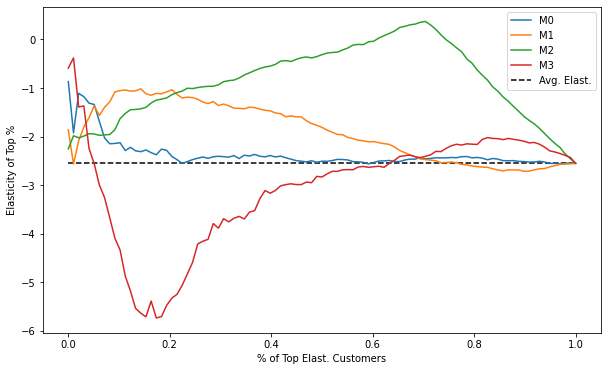

In [428]:
plt.figure(figsize=(10,6))

for m in range(4):
    cumm_gain = top_n_elast_curve(prices_rnd_pred, f"m{m}_pred", "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumm_gain)))
    plt.plot(x/x.max(), cumm_gain, label=f"M{m}")

plt.hlines(elast(prices_rnd, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.legend();

In [418]:
def cummulative_elasticity(dataset, y, t, min_periods=2, steps=100):
    
    size = dataset.shape[0]

    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([elast(dataset.head(rows), y, t) * (rows/size) # add normalizer
                     for rows in n_rows])

def elast_curve(dataset, prediction, y, t, min_periods=2, steps=100):
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    return cummulative_elasticity(ordered_df, y, t, min_periods, steps)

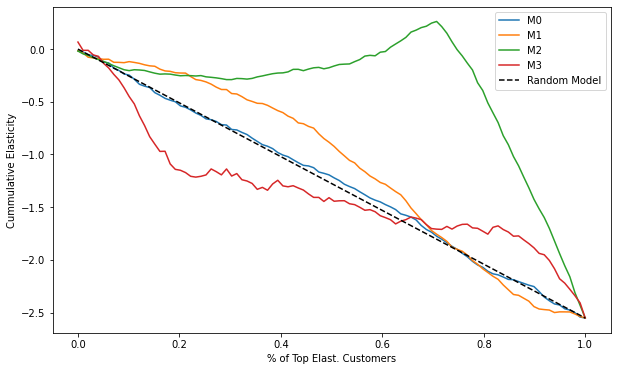

In [419]:
plt.figure(figsize=(10,6))

for m in range(4):
    cumm_gain = elast_curve(prices_rnd_pred, f"m{m}_pred", "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumm_gain)))
    plt.plot(x/x.max(), cumm_gain, label=f"M{m}")
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.legend();

## Non Random Data

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

## Debiasing the Test

In [11]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,0.004613,-0.012878,0.015497,0.329350
weekday,0.004613,1.000000,0.024100,0.000908,-0.007974
cost,-0.012878,0.024100,1.000000,0.400739,-0.198123
price,0.015497,0.000908,0.400739,1.000000,-0.403409
sales,0.329350,-0.007974,-0.198123,-0.403409,1.000000


In [12]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**dict(price=test["price"] - m_t.predict(test), 
                                   sales=test["sales"] - m_y.predict(test)))

In [13]:
debiased_test.corr()

,temp,weekday,cost,price,sales
temp,1.000000e+00,4.612868e-03,-1.287840e-02,8.956334e-16,5.156351e-16
weekday,4.612868e-03,1.000000e+00,2.409966e-02,-1.647475e-16,-7.517912e-16
cost,-1.287840e-02,2.409966e-02,1.000000e+00,-5.057786e-16,-4.944055e-16
price,8.956334e-16,-1.647475e-16,-5.057786e-16,1.000000e+00,-9.668635e-01
sales,5.156351e-16,-7.517912e-16,-4.944055e-16,-9.668635e-01,1.000000e+00


In [14]:
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

In [15]:
debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,m3_pred
7079,20.5,6,1.5,0.564646,-17.975002,-25.098470
8219,27.5,1,1.0,-0.323774,-4.220031,-18.082602
1810,17.1,2,0.3,1.814708,-57.746207,-26.137948
443,23.1,3,1.0,1.696407,-46.674546,-24.383961
350,23.4,7,0.5,-0.561861,14.117272,-18.905815


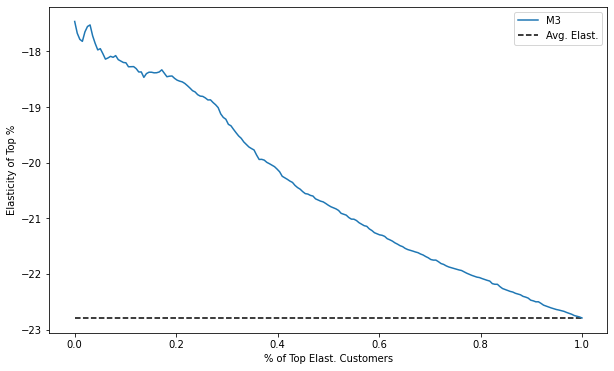

In [16]:
plt.figure(figsize=(10,6))

cumm_gain = top_n_elast_curve(debiased_test_pred, f"m{m}_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M{m}")

plt.hlines(elast(debiased_test_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.legend();

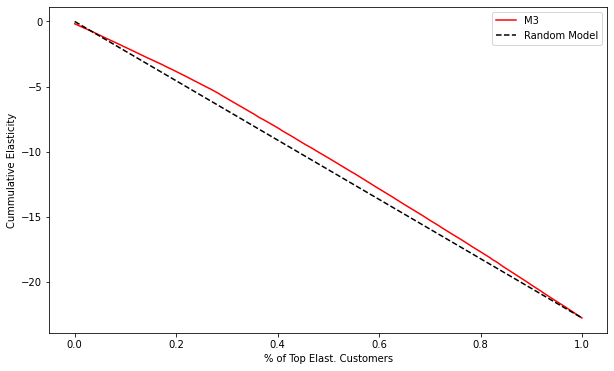

In [17]:
plt.figure(figsize=(10,6))

cumm_gain = elast_curve(debiased_test_pred, f"m{m}_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M{m}", color="red")
plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.legend();

## How Bias Affects it?

In [18]:
def gen_price_data(bias, n=10000):
    temp = np.random.normal(24, 4, n).round(1)
    price = np.random.normal(5 + temp).round(1)
    cost = np.random.choice(np.arange(0.3, 4, 0.25), n)
    sales = np.random.normal(50 + bias*temp - 20*price + 5*price*cost)
    return pd.DataFrame(dict(temp=temp, price=price, cost=cost, sales=sales))

In [19]:
def split(data):
    return train_test_split(data, test_size=0.5)


def predict_elast(model, data):
    pred = model.predict(data.assign(price=data["price"]+1)) - model.predict(data)
    return data.assign(**{"pred_elast": pred}) 


def train_model(train_data):
    m = smf.ols("sales ~ price*cost", data=train_data).fit()
    return lambda df: predict_elast(m, df)

def eval_elast(test):
    return top_n_elast_curve(test, f"pred_elast", "sales", "price", min_periods=50, steps=200)

In [20]:
def run_eval_round(bias, eval_fn):
    np.random.seed(212)
    df = gen_price_data(bias, n=10000)
    train, test = split(df)
    
    pred_fn = train_model(train)
    
    return eval_fn(pred_fn(test), f"pred_elast", "sales", "price", min_periods=50, steps=200)
    

In [21]:
bias = range(0, 20, 4)
bias_exp = [run_eval_round(bias, top_n_elast_curve) for bias in bias]

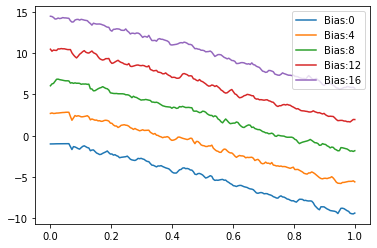

In [22]:
for experiment, b in zip(bias_exp, bias):
    x = np.array(range(len(experiment)))
    plt.plot(x/x.max(), experiment, label=f"Bias:{b}")
    
plt.legend();

In [23]:
bias = range(0, 20, 4)
bias_exp = [run_eval_round(bias, elast_curve) for bias in bias]

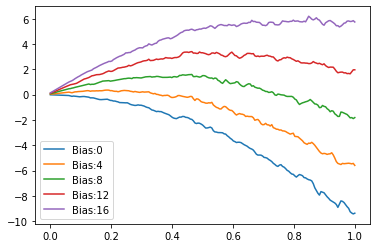

In [24]:
for experiment, b in zip(bias_exp, bias):
    x = np.array(range(len(experiment)))
    plt.plot(x/x.max(), experiment, label=f"Bias:{b}")
    
plt.legend();